In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor


from sklearn.metrics import *


# Loading Data, splitting into train, validation(dev) and test


In [21]:
ass3_pickle_file_path = r"C:\Users\Administrator\Downloads\ass3.pickle"
# Load pickle file
df = pd.read_pickle(ass3_pickle_file_path)
train,dev,test = df['train'],df['dev'],df['test']
train = train.reset_index(drop=True)
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,target
0,4.0391,15.0,6.297710,0.992366,334.0,2.549618,32.72,-116.99,1.695
1,4.7241,46.0,5.375758,0.954545,753.0,2.281818,34.17,-118.10,2.796
2,3.3553,7.0,5.229213,1.101124,1304.0,2.930337,32.70,-117.01,1.322
3,1.3929,52.0,5.000000,0.953488,126.0,2.930233,37.92,-122.36,1.042
4,1.6006,52.0,4.427083,1.017361,1246.0,2.163194,34.07,-117.75,1.462


Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12384 entries, 0 to 12383
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      12210 non-null  float64
 1   f1      12244 non-null  float64
 2   f2      12226 non-null  float64
 3   f3      12228 non-null  float64
 4   f4      12215 non-null  float64
 5   f5      12242 non-null  float64
 6   f6      12233 non-null  float64
 7   f7      12236 non-null  float64
 8   target  12384 non-null  float64
dtypes: float64(9)
memory usage: 870.9 KB
None
Train Null Value Counts:
f0        174
f1        140
f2        158
f3        156
f4        169
f5        142
f6        151
f7        148
target      0
dtype: int64

Dev Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 1473 to 6192
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      4128 non-null   float64
 1   f1      41

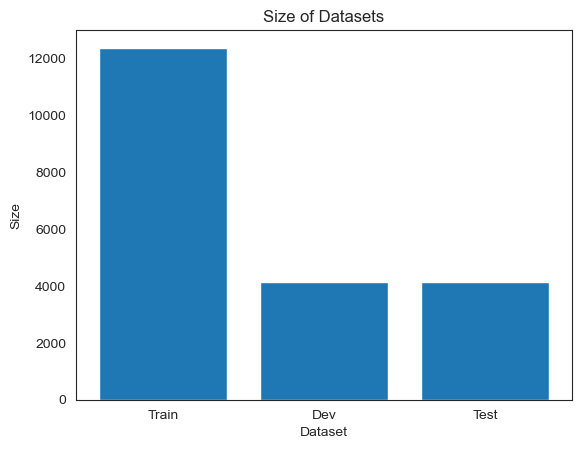

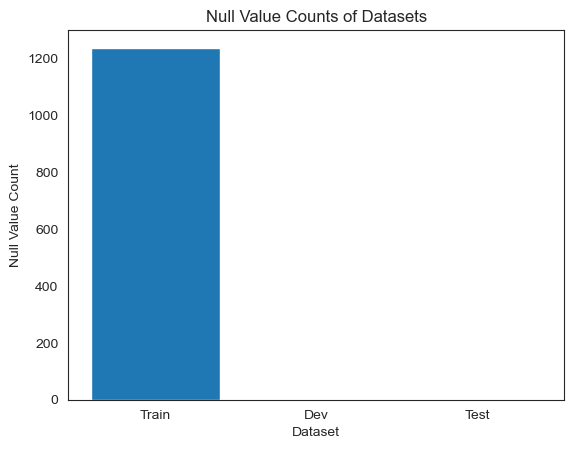

In [22]:
datasets = [("Train", train), ("Dev", dev), ("Test", test)]

sizes = []
null_counts = []

for dataset_name, dataset in datasets:
    sizes.append(len(dataset))
    null_counts.append(dataset.isnull().sum().sum())

    print(f"{dataset_name} Dataset Info:")
    print(dataset.info())

    print(f"{dataset_name} Null Value Counts:")
    if null_counts[-1] == 0:
        print(f'{dataset_name} has no Null Values')
    else:
        print(dataset.isnull().sum())
    print()

# Plot the size of each dataset
plt.bar([dataset[0] for dataset in datasets], sizes)
plt.xlabel("Dataset")
plt.ylabel("Size")
plt.title("Size of Datasets")
plt.show()

# Plot the null value counts of each dataset
plt.bar([dataset[0] for dataset in datasets], null_counts)
plt.xlabel("Dataset")
plt.ylabel("Null Value Count")
plt.title("Null Value Counts of Datasets")
plt.show()

# Check how Nan values varies

Number of unique samples with NaN values: 1238


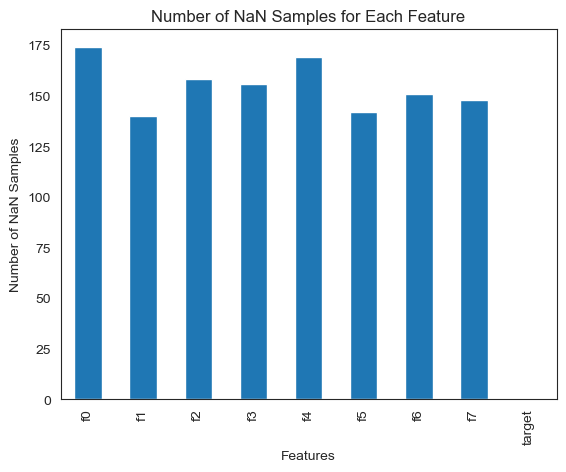

Percentage of samples with NaN values: 9.996770025839794


In [23]:
nan_samples = train[train.isnull().any(axis=1)].drop_duplicates().shape[0]

# Print the count of unique samples with NaN values
print("Number of unique samples with NaN values:", nan_samples)

import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named "train"
# Calculate the number of NaN samples for each feature
nan_counts = train.isnull().sum()

# Plot the number of NaN samples for each feature
nan_counts.plot(kind='bar')
plt.xlabel("Features")
plt.ylabel("Number of NaN Samples")
plt.title("Number of NaN Samples for Each Feature")
plt.show()

# Calculate the percentage of samples with NaN values
percentage_nan_samples = (train.isnull().any(axis=1).sum() / len(train)) * 100

# Print the percentage of samples with NaN values
print("Percentage of samples with NaN values:", percentage_nan_samples)



# As allmost 10% of the Train dataset contains Nans, We will not remove the samples but handle them using sklearn Imputer

In [24]:

imputer = SimpleImputer(strategy='mean')
imputer.fit(train)
train_imputed = pd.DataFrame(imputer.transform(train), columns=train.columns)
train = train_imputed

<AxesSubplot:>

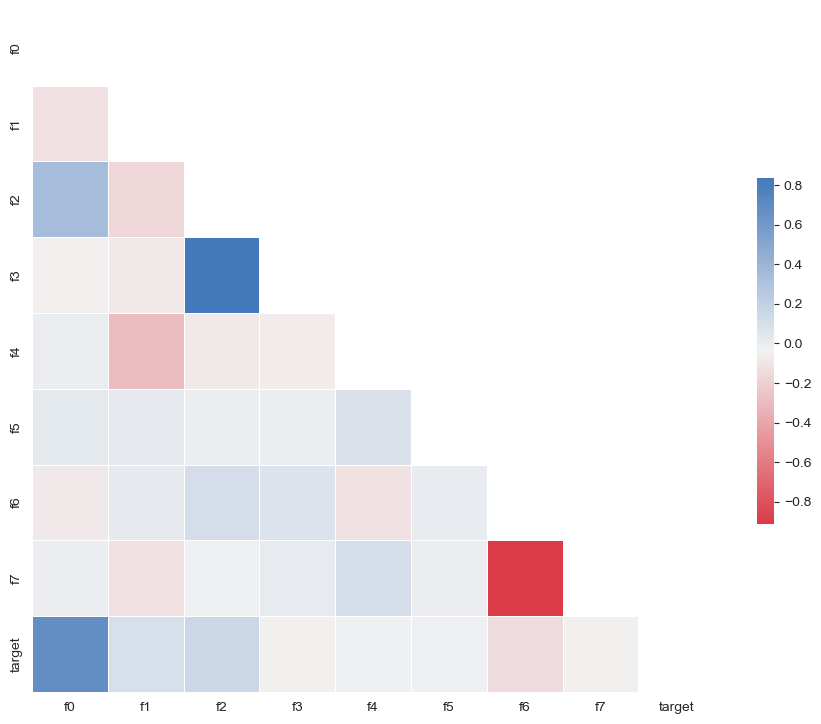

In [25]:
corr = train_imputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

#Detect strong correlations


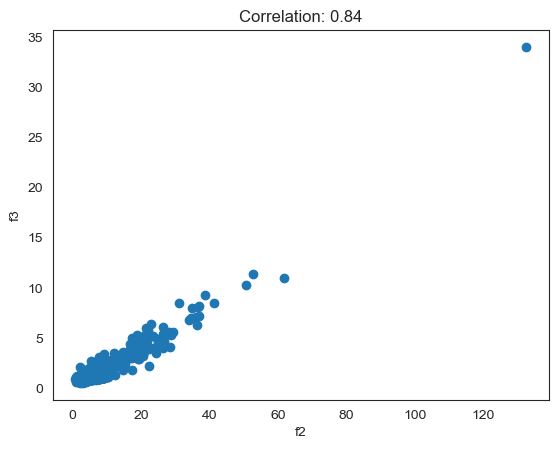

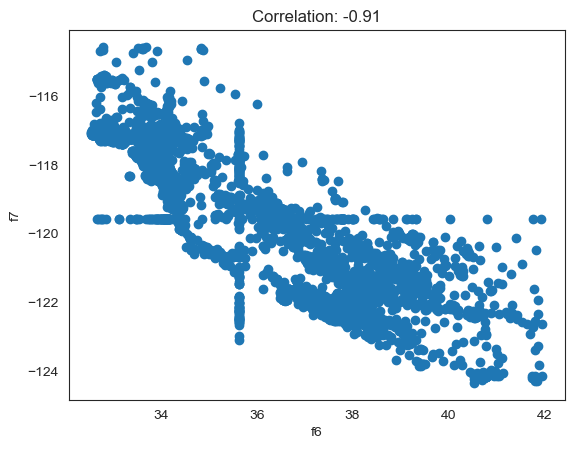

Strong pair might be removed or merged in some way


In [26]:
threshold = 0.8

strong_correlations = [(f1, f2, correlation)
                       for i, f1 in enumerate(corr.columns)
                       for j, f2 in enumerate(corr.columns[i+1:], start=i+1)
                       if abs(correlation := corr.iloc[i, j]) > threshold]

# Find the strong correlations pairs
for feature1, feature2, correlation in strong_correlations:
    plt.scatter(train[feature1], train[feature2])
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f"Correlation: {correlation:.2f}")
    plt.show()

print('Strong pair might be removed or merged in some way')

# Train, Validation and Test Sepearion

In [27]:
X_train, X_validation = train.loc[:, train.columns != 'target'] ,dev.loc[:, dev.columns != 'target']
y_train, y_validation =  train['target'], dev['target']
X_test  = test.loc[:, test.columns != 'target'] 
y_test =  test['target']


# Scale Features
Some regressors may benefit from feature normalization to improve their performance and some regularization techniques, such as Lasso or Ridge regularization, assume that the features are on a similar scale.

In [28]:

scaler = StandardScaler()
scaler.fit(X_train)
# Transform features
X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)


# Training RF regressor and validation top feature importance




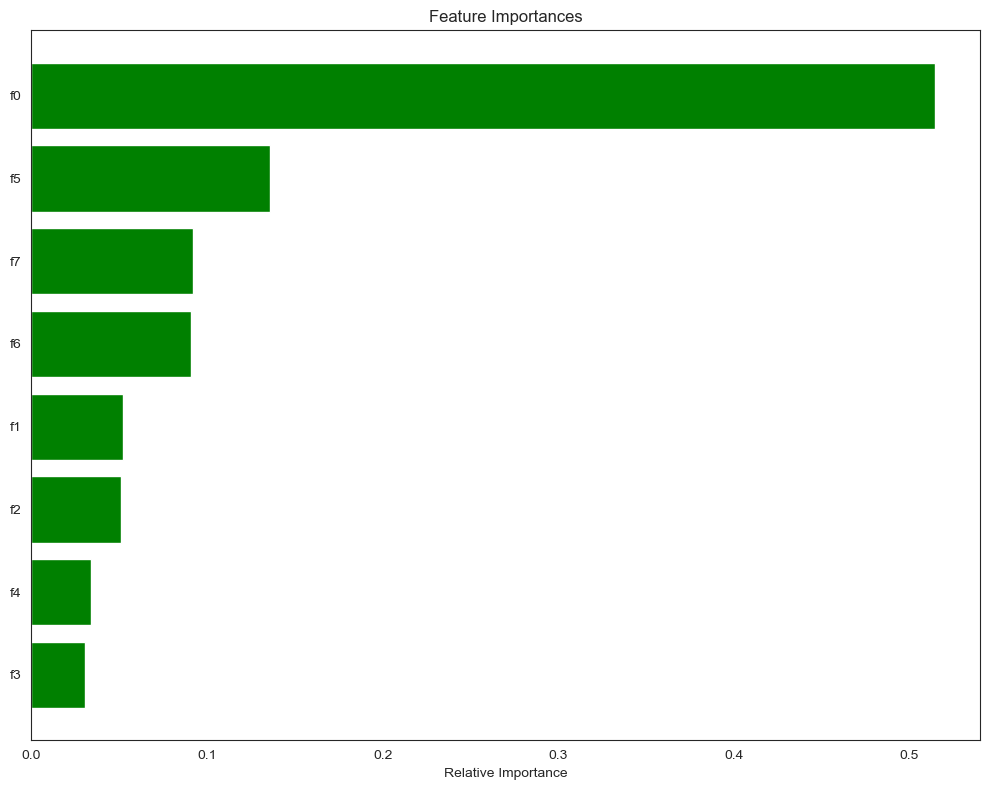

In [29]:
# Fitting the model
model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=100)
model.fit(X_train, y_train)
# Plotting feature importances
features = train.drop('target', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.tight_layout()
plt.show()


# Defining different models and hyper params

In [30]:

regressors = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    LGBMRegressor(),
    XGBRegressor()
]




# 1.Run expirment, use Train for training, Dev for validation.
# 2.Use GridSearchCV for hyperParam assessment 
# 3.Use MSE metric to choose the Best Model
# 4.Build an Ensemble using top 3 models

-----------------------------------------

Hyper Params explained

**solver** (used for Ridge Regression): 

Determines the optimization algorithm used.

**selection** (used for both Lasso, ElasticNet): 

Controls how coefficients are selected.

**gamma** (used for SVR): 

Determines the kernel coefficient for certain kernels.

**min_samples_split** (used for both DecisionTreeRegressor, RandomForestRegressor):

 Specifies the minimum number of samples needed to split a node.

learning_rate (used for both GradientBoostingRegressor, AdaBoostRegressor): 

Controls the step size during boosting iterations.


In [31]:

params_grid = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 1.0, 5.0, 10.0]},
    'Lasso': {'alpha': [0.1, 1.0, 5.0, 10.0]},
    'ElasticNet': {'alpha': [0.1, 1.0, 5.0, 10.0], 'l1_ratio': [0.25, 0.5, 0.75]},
    'SVR': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']},
    'DecisionTreeRegressor': {'max_depth': [None, 5, 10]},
    'RandomForestRegressor': {'n_estimators': [100, 300, 500], 'max_depth': [None, 5, 10]},
    'GradientBoostingRegressor': {'n_estimators': [100, 300, 500], 'learning_rate': [0.1, 0.01]},
    'AdaBoostRegressor': {'n_estimators': [100, 300, 500], 'learning_rate': [0.1, 0.01]},
    'LGBMRegressor': {'n_estimators': [100, 300, 500], 'learning_rate': [0.1, 0.01]},
    'XGBRegressor': {'n_estimators': [100, 300, 500], 'learning_rate': [0.1, 0.01]}
}

# Create a dictionary to store the best models
best_models = {}

# Perform grid search for each regressor and select the best model based on performance
for regressor in regressors:
    regressor_name = regressor.__class__.__name__
    grid_search = GridSearchCV(regressor, params_grid[regressor_name], cv=5, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    # Assess model over validation dataset using the MSE metric
    mse = mean_squared_error(y_validation, best_model.predict(X_validation))
    best_models[regressor_name] = (best_model, mse)

# Select top 3 models for building an Ensemble Regressor
top_models = sorted(best_models.items(), key=lambda x: x[1][1])[:3]

for regressor_name, (best_model, mse) in top_models:
    print(f"{regressor_name} Best Model:")
    print(best_model)
    print(f"{regressor_name} Best Hyperparameters:")
    print(best_model.get_params())
    
# Set up the ensemble regressor from top 3 models
ensemble = VotingRegressor(estimators=[(t[0],t[1][0]) for t in top_models])
# Fit the ensemble on the training data
ensemble.fit(X_train, y_train)
#Ensemble MSE over the validation dataset
ensemble_mse = mean_squared_error(y_validation, ensemble.predict(X_validation))
print(f"ensemble mse:, {ensemble_mse}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=1.0; total tim

In [32]:
regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Top models (Name, Model, MSE)

In [33]:
top_models

[('LGBMRegressor', (LGBMRegressor(n_estimators=500), 0.20536290573886634)),
 ('XGBRegressor',
  (XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=500, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=None, ...),
   0.21566359166257829)),
 ('GradientBoostingRegressor',
  (GradientBoostingRegressor(n_estimators=500), 0.24323372148414027))]

# Ensemle Object

In [34]:
ensemble

VotingRegressor(estimators=[('LGBMRegressor', LGBMRegressor(n_estimators=500)),
                            ('XGBRegressor',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          impo...
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=500, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...)),
                            ('GradientBoostingRegressor',
                             GradientBoostingRegressor(n_estimators=500))])

# Evaluate the Ensemble model over the Test set
Using MSE and R2 metrics

In [35]:

y_pred = ensemble.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'The Ensemble results for the Test set are MSE of {mse} and R2 score of {r2}')

The Ensemble results for the Test set are MSE of 0.21067725635131032 and R2 score of 0.8489702754421913
